Please note that this document reads from a folder directory called results_dir

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#MAY NEED TO RUN A COUPLE OF TIMES IF IT SAYS TO RESTART THE RUNTIME
from PIL import Image  # this contain the image class and methods from PIL library
import numpy as np # this imports the numerical and array library 
import matplotlib.pyplot as plt # this is for plotting (showing) images
from skimage import measure
import matplotlib as mpl

import cv2
import sklearn
import tensorflow as tf
!pip install opencv-contrib-python==3.4.2.17

from sklearn.neighbors import KDTree

In [ ]:
#Gets a frame from a video
def get_frame(video_number, frame_number):
    #Get the video
    video = cv2.VideoCapture('drive/My Drive/CS413_IVA_Coursework/DATA/video-00' + str(video_number) + '.MOV')
    for i in range(frame_number):
        #Stores whether a frame was read and the frame in BGR form (by default) if there is one
        success, frame_image_BGR = video.read()
    if (success == False):
        print("Frame number does not exist")
    else:
        #Return the RGB form of the frame image
        frame_image_RGB = cv2.cvtColor(frame_image_BGR ,cv2.COLOR_BGR2RGB)
        return frame_image_RGB

In [ ]:
#Find the coordinate bounding box of a given label in a components image
def bounding_box(comps, label):
    #Array of image coordinates in x and y
    xx, yy = np.meshgrid(np.arange(0,comps.shape[1]), np.arange(0,comps.shape[0]))

    #Mask/select by where value is given label (component)
    where_x = xx[comps==label]
    where_y = yy[comps==label]
    
    #Find min and max extents of coordinates
    return np.min(where_x), np.min(where_y), np.max(where_x), np.max(where_y)

In [ ]:
#Get the saved card images from the train-XXX.jpg image files from the drive and save them in a list
cards_train = []
for j in range(1, 17):
    #Read the image (as BGR by default) 
    im_bgr = cv2.imread('drive/My Drive/CS413_IVA_Coursework/results_dir/train1, ' + str(j) + '.jpg')
    #Convert image to RGB
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
    #Add numpy RGB form of image to the list
    im_rgb = np.asarray(im_rgb)
    cards_train.append(im_rgb)
for i in range(2, 11):
    for j in range(1, 19):
        im_bgr = cv2.imread('drive/My Drive/CS413_IVA_Coursework/results_dir/train' + str(i) + ', ' + str(j) + '.jpg')
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        im_rgb = np.asarray(im_rgb)
        cards_train.append(im_rgb)
for i in range(12, 14):
    for j in range(1, 19):
        im_bgr = cv2.imread('drive/My Drive/CS413_IVA_Coursework/results_dir/train' + str(i) + ', ' + str(j) + '.jpg')
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        im_rgb = np.asarray(im_rgb)
        cards_train.append(im_rgb)
for j in range(1, 12):
    im_bgr = cv2.imread('drive/My Drive/CS413_IVA_Coursework/results_dir/train14, ' + str(j) + '.jpg')
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
    im_rgb = np.asarray(im_rgb)
    cards_train.append(im_rgb)

In [ ]:
#Stores the labels of each card image from the train-XXX.jpg files in the order that they are saved to the drive
#Each new image starts on a new line
labels = [5, 67, 52, 35, 40, 18, 31, 47, 52, 33, 210, 33, 54, 63, 26, 36, 33, 48,
73, 57, 57, 54, 89, 17, 60, 66, 54, 57, 76, 33, 68, 25, 68, 33, 63, 83,
36, 56, 65, 89, 44, 4, 96, 15, 59, 15, 63, 11, 69, 1, 89, 1, 62, 56,
54, 17, 89, 57, 57, 73, 76, 57, 54, 66, 33, 60, 68, 63, 33, 25, 83, 68,
31, 26, 48, 36, 33, 54, 52, 67, 52, 210, 47, 33, 40, 18, 35, 33, 63, 5,
7, 92, 63, 96, 54, 11, 42, 82, 24, 45, 37, 11, 98, 21, 65, 28, 2, 24,
160, 150, 177, 192, 161, 87, 138, 164, 183, 124, 190, 104, 101, 135, 115, 142, 168, 114,
109, 147, 139, 136, 106, 129, 146, 186, 182, 109, 154, 108, 198, 151, 127, 189, 108, 146,
196, 134, 174, 103, 198, 192, 114, 190, 147, 182, 154, 192, 142, 146, 148, 133, 174, 191,
172, 133, 134, 182, 171, 120, 181, 172, 189, 156, 111, 181, 139, 106, 156, 184, 139, 131,
150, 162, 165, 139, 139, 121, 139, 112, 125, 112, 136, 170, 127, 135, 181, 114, 109, 198,
121, 193, 168, 162, 119, 112, 151, 187, 104, 121, 168]

In [ ]:
#Identifies the image cards in a video fram
def identify_frame(video, frame):
    cards = []
    #Get tge frame
    im = get_frame(video, frame)
    #Change green to white
    image_thresh = np.all(np.logical_and(im > [0, 80, 0], im < [160, 255, 160]), axis = 2)
    for ii in range(im.shape[0]):
        for jj in range(im.shape[1]):
            if image_thresh[ii][jj] == True:
                for kk in range(im.shape[2]):
                    im[ii][jj][kk] = 255
    
    image_grey = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

    image_grey_thresh = (image_grey < 254)

    #Extract all connected components
    comps = measure.label(image_grey_thresh, background = False)
    #Refine down to unique labels
    unique = np.unique(comps)

    #Bounds on the size of card images that we want
    min_size = 20000
    max_size = 1000000
    for l in unique:
        #Make a binary image for each component
        one_comp = np.zeros(comps.shape, dtype = 'uint8')
        one_comp[comps == l] = 1

        #Measure the size of the component
        n = np.count_nonzero(one_comp)

        #Save the card image to the drive if it is within the set size
        if (n > min_size) and (n < max_size):
            #Get the coordinate bounding box of a given label in a components image
            bb = bounding_box(comps, label = l)
            #Extract the bounding box region of the BGR and RGB images
            one_comp_bgr = im[bb[1]:bb[3],bb[0]:bb[2]]
            one_comp_rgb = im[bb[1]:bb[3],bb[0]:bb[2]]
            cards.append(one_comp_rgb)
    cards = np.asarray(cards)

    #Use sift to get the keypoints and descriptors of each image card from a train-XXX.jpg file
    sift = cv2.xfeatures2d.SIFT_create()
    kps_cards = []
    descs_cards = []
    #The lists contain a list for each image 
    for i in range(len(cards)):
        kp, des = sift.detectAndCompute(cards[i], None)
        kps_cards.append(kp)
        descs_cards.append(des)
    
    #Use sift to get the keypoints and descriptors of each image card from a train-XXX.jpg file
    siftB = cv2.xfeatures2d.SIFT_create()
    kps_train = []
    descs_train = []
    #The lists contain a list for each image 
    for i in range(len(cards_train)):
        kp, des = siftB.detectAndCompute(cards_train[i], None)
        kps_train.append(kp)
        descs_train.append(des)

    for p in range(len(cards)):
        #Stores the number of matches of the image with all other images
        matchesB = np.zeros(225 - 16)

        #Count and store the number of matches of the image with every other image
        for img2 in range(16, 225):
            #Use a KD tree to make it faster
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            search_params = dict(checks = 50)
            #Make FLANN searcher
            flann = cv2.FlannBasedMatcher(index_params, search_params)

            #Get the descriptors of each image
            des1 = descs_cards[p]
            des2 = descs_train[img2]

            #Find the matches
            matches = flann.knnMatch(des1, des2, k = 2)

            #Count the number of good matches (those that survive Lowes pruning strategy)
            good_matches = 0
            for match in matches:
                if (match[0].distance < match[1].distance * 0.7):
                    good_matches = good_matches + 1
            
            matchesB[img2 - 16] = good_matches
    
        #Find the image with the most matches
        max_index = matchesB.argmax() + 16

        #Plot the original card
        plt.subplot(1, 2, 1)
        plt.imshow(cards[p])
        plt.axis('off')
        plt.title('Original')

        #Plot and label the closest card
        plt.subplot(1, 2, 2)
        plt.imshow(cards_train[max_index])
        plt.axis('off')
        plt.title('Closest match')

        plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


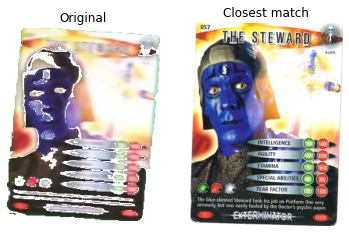

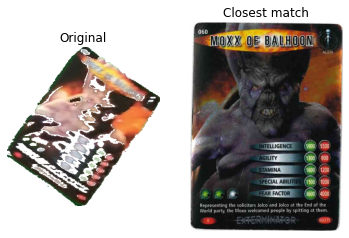

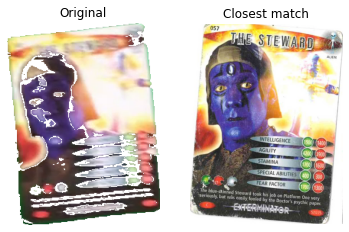

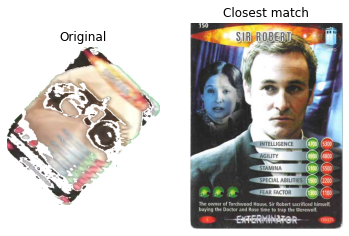

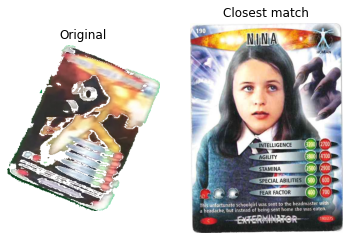

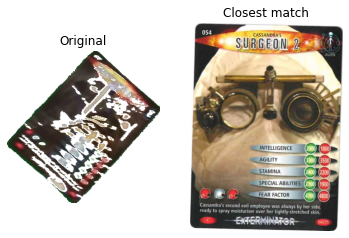

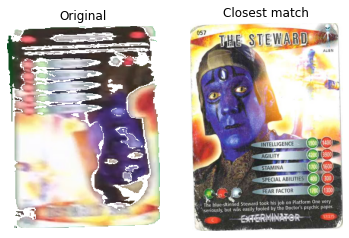

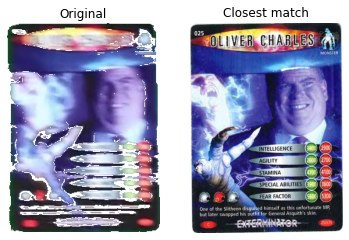

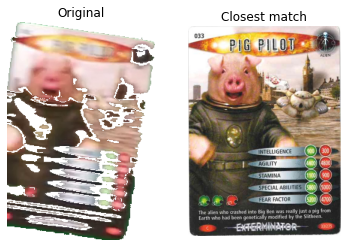

In [ ]:
identify_frame(1,60)